In [1]:
# Import necessary libraries

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from keras.applications import InceptionV3
from keras.callbacks import TensorBoard
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import random
import os
from keras import regularizers

In [2]:
pwd = os.getcwd()

In [3]:
dataset_path = pwd + "\\dataset.csv"

In [4]:
# Load the dataset into a datframe
df = pd.read_csv(dataset_path)
df.head()

,image,gender_index,age,gender
0,c:\Users\sweek\OneDrive - Lambton College\Proj...,0,100,Male
1,c:\Users\sweek\OneDrive - Lambton College\Proj...,0,100,Male
2,c:\Users\sweek\OneDrive - Lambton College\Proj...,0,100,Male
3,c:\Users\sweek\OneDrive - Lambton College\Proj...,0,100,Male
4,c:\Users\sweek\OneDrive - Lambton College\Proj...,1,100,Female


In [5]:
df['gender'] = df['gender'].astype(str)

In [6]:
# Split the dataset into train, val and test set

train_df, test_df = train_test_split(df, test_size=0.15, random_state=42)
train_df, val_df = train_test_split(df, test_size=0.15, random_state=42)

In [7]:
train_df.head()

,image,gender_index,age,gender
3704,c:\Users\sweek\OneDrive - Lambton College\Proj...,1,22,Female
8570,c:\Users\sweek\OneDrive - Lambton College\Proj...,0,28,Male
4372,c:\Users\sweek\OneDrive - Lambton College\Proj...,0,24,Male
7335,c:\Users\sweek\OneDrive - Lambton College\Proj...,1,26,Female
14147,c:\Users\sweek\OneDrive - Lambton College\Proj...,1,36,Female


Class ditribution in train set

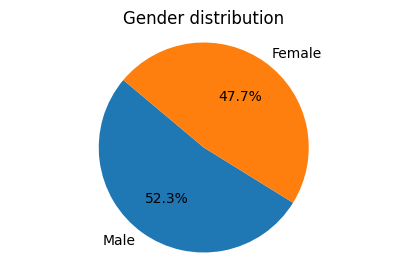

In [8]:
genders = train_df['gender'].value_counts()

plt.figure(figsize=(5,3))
plt.pie(genders, labels=genders.index, autopct='%1.1f%%', startangle=140)
plt.title("Gender distribution")
plt.axis("equal")
plt.plot();

In [9]:
test_df.head()

,image,gender_index,age,gender
4273,c:\Users\sweek\OneDrive - Lambton College\Proj...,0,24,Male
1147,c:\Users\sweek\OneDrive - Lambton College\Proj...,1,17,Female
1190,c:\Users\sweek\OneDrive - Lambton College\Proj...,1,17,Female
18715,c:\Users\sweek\OneDrive - Lambton College\Proj...,0,53,Male
6602,c:\Users\sweek\OneDrive - Lambton College\Proj...,0,26,Male


Class distribution in test set

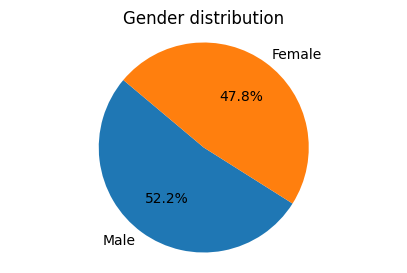

In [10]:
genders = test_df['gender'].value_counts()

plt.figure(figsize=(5,3))
plt.pie(genders, labels=genders.index, autopct='%1.1f%%', startangle=140)
plt.title("Gender distribution")
plt.axis("equal")
plt.plot();

In [11]:
val_df.head()

,image,gender_index,age,gender
4273,c:\Users\sweek\OneDrive - Lambton College\Proj...,0,24,Male
1147,c:\Users\sweek\OneDrive - Lambton College\Proj...,1,17,Female
1190,c:\Users\sweek\OneDrive - Lambton College\Proj...,1,17,Female
18715,c:\Users\sweek\OneDrive - Lambton College\Proj...,0,53,Male
6602,c:\Users\sweek\OneDrive - Lambton College\Proj...,0,26,Male


Class distribution in validation set

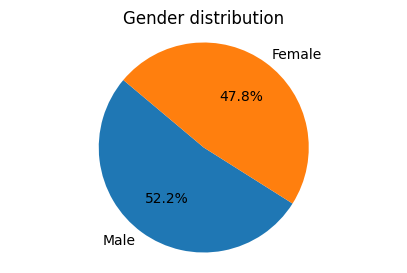

In [12]:
genders = val_df['gender'].value_counts()

plt.figure(figsize=(5, 3))
plt.pie(genders, labels=genders.index, autopct='%1.1f%%', startangle=140)
plt.title("Gender distribution")
plt.axis("equal")
plt.plot();

In [7]:
# Preprocess the images before feeding it to the model

datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
)

In [8]:
# Set the image size to feed the model

batch_size = 32
img_height = 224
img_width = 224

In [8]:
# Train data generator

train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image',
    y_col='gender_index',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='raw',  # Use 'raw' to handle integer labels
    shuffle=True  # Shuffle the training data
)

Found 20153 validated image filenames.


ValueError: num must be an integer with 1 <= num <= 9, not 10

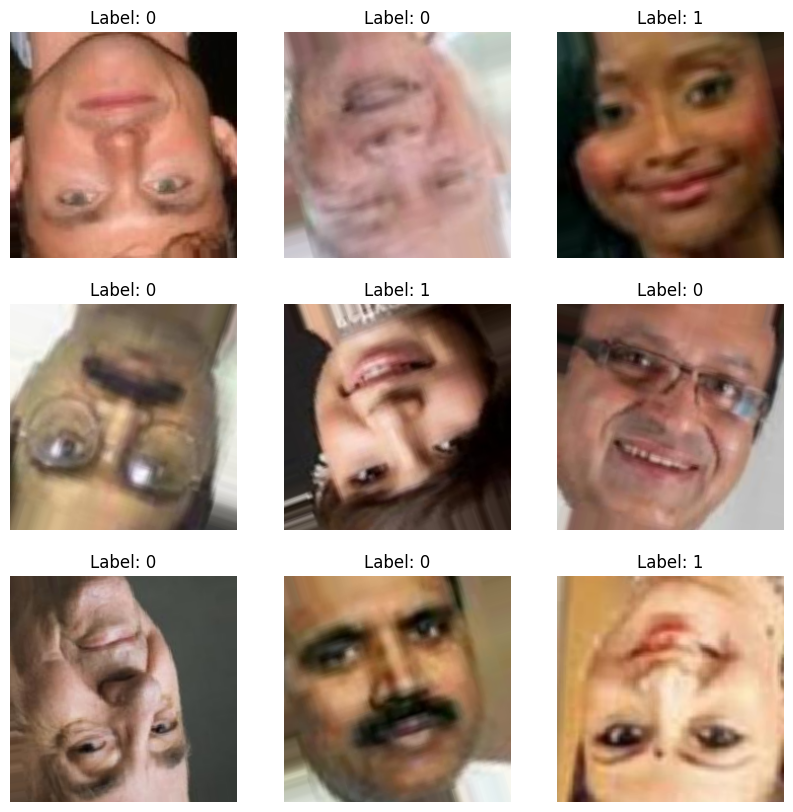

In [16]:
# View the output of train data generator
import matplotlib.pyplot as plt

# Retrieve a batch of data and labels from the generator
batch_images, batch_labels = next(train_gen)

# Plot the images
plt.figure(figsize=(10, 10))
for i in range(len(batch_images)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(batch_images[i])
    plt.title(f"Label: {batch_labels[i]}")
    plt.axis("off")
plt.show()


In [9]:
# Validation data generator

val_gen = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image',
    y_col='gender_index',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='raw',  # Use 'raw' to handle integer labels
    shuffle=False  # No need to shuffle validation data
)

Found 3557 validated image filenames.


Model creation begins, defining the layers

In [18]:
# Define the Sequential model
model = Sequential()

# Add convolutional layers for feature extraction
model.add(Conv2D(128, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))

# Flatten the output for the fully connected layers
model.add(Flatten())

# Add fully connected layers for classification
model.add(Dense(64, activation='relu'))

model.add(Dense(1, activation='sigmoid')) # output layer

c:\Users\sweek\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,179,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,284,865 (4.90 MB)

 Trainable params: 1,284,865 (4.90 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
from keras.callbacks import ModelCheckpoint

# Define a filepath to save the best model checkpoint
checkpoint_filepath = r'C:\Users\sweek\OneDrive - Lambton College\Projects Main\Age and Gender Prediction\Gender_Model\best_CNN_model.keras'  # You can change the filename and path as needed

# Define the ModelCheckpoint callback
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,  # Save only the best model
    monitor='val_accuracy',  # Monitor validation loss (you can change this to other metrics)
    mode='max',  # Minimize the monitored metric (for loss, use 'min'; for accuracy, use 'max')
    verbose=1  # Display messages when saving checkpoints
)

Epoch 1/20


c:\Users\sweek\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


630/630 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6583 - loss: 0.6325
Epoch 1: val_accuracy improved from -inf to 0.76272, saving model to C:\Users\sweek\OneDrive - Lambton College\Projects Main\Age and Gender Prediction\Gender_Model\best_CNN_model.keras
630/630 ━━━━━━━━━━━━━━━━━━━━ 1009s 2s/step - accuracy: 0.6584 - loss: 0.6324 - val_accuracy: 0.7627 - val_loss: 0.5044
Epoch 2/20
630/630 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7743 - loss: 0.4696
Epoch 2: val_accuracy improved from 0.76272 to 0.77593, saving model to C:\Users\sweek\OneDrive - Lambton College\Projects Main\Age and Gender Prediction\Gender_Model\best_CNN_model.keras
630/630 ━━━━━━━━━━━━━━━━━━━━ 1007s 2s/step - accuracy: 0.7743 - loss: 0.4696 - val_accuracy: 0.7759 - val_loss: 0.4805
Epoch 3/20
630/630 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7988 - loss: 0.4306
Epoch 3: val_accuracy improved from 0.77593 to 0.82541, saving model to C:\Users\sweek\OneDrive - Lambton College\Projects Main\Age and Gender Pr

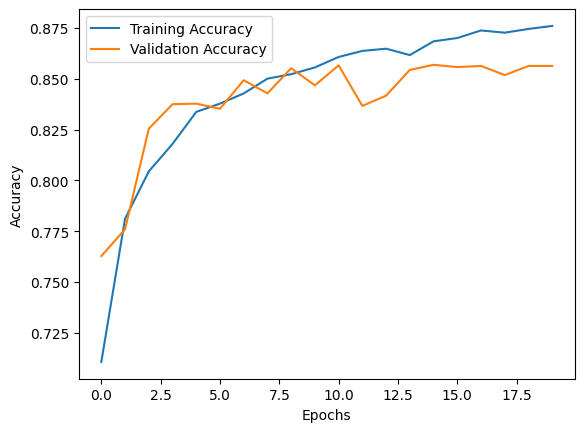

In [22]:
# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,  # Adjust the number of epochs as needed
    batch_size = 32,
    callbacks=[model_checkpoint_callback]
)

# Visualize training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

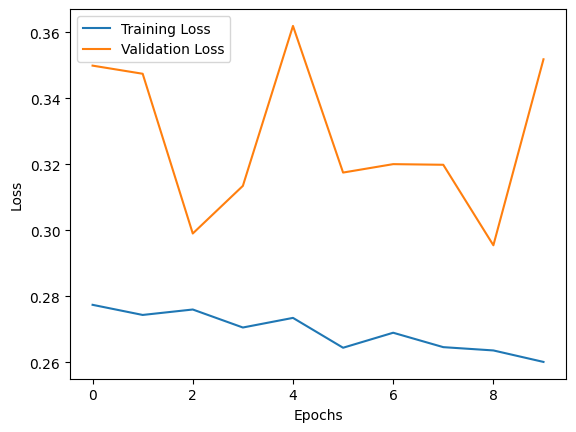

In [27]:
# Visualize training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/5
630/630 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8830 - loss: 0.2589
Epoch 1: val_accuracy did not improve from 0.87236
630/630 ━━━━━━━━━━━━━━━━━━━━ 857s 1s/step - accuracy: 0.8830 - loss: 0.2589 - val_accuracy: 0.8696 - val_loss: 0.2955
Epoch 2/5
630/630 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8876 - loss: 0.2627
Epoch 2: val_accuracy did not improve from 0.87236
630/630 ━━━━━━━━━━━━━━━━━━━━ 843s 1s/step - accuracy: 0.8876 - loss: 0.2627 - val_accuracy: 0.8476 - val_loss: 0.3440
Epoch 3/5
630/630 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8883 - loss: 0.2564
Epoch 3: val_accuracy did not improve from 0.87236
630/630 ━━━━━━━━━━━━━━━━━━━━ 846s 1s/step - accuracy: 0.8883 - loss: 0.2564 - val_accuracy: 0.8628 - val_loss: 0.3138
Epoch 4/5
630/630 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8865 - loss: 0.2628
Epoch 4: val_accuracy did not improve from 0.87236
630/630 ━━━━━━━━━━━━━━━━━━━━ 941s 1s/step - accuracy: 0.8865 - loss: 0.2628 - val_accuracy: 0.8586 - val_l

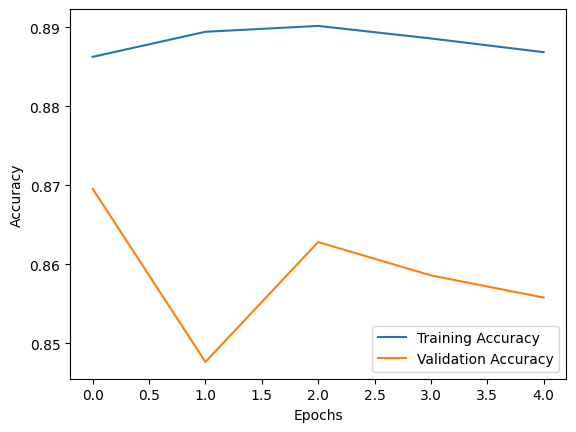

In [28]:
# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,  # Adjust the number of epochs as needed
    batch_size = 32,
    callbacks=[model_checkpoint_callback]
)

# Visualize training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [9]:
 # Get a batch of test data
test_gen = datagen.flow_from_dataframe(
      dataframe=test_df,
      x_col='image',
      y_col='gender_index',  # Assuming integer labels for gender
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='raw',  # Handle integer labels
      shuffle=False  # Don't shuffle during testing for correct image order
  )

Found 3557 validated image filenames.


In [17]:
test_df

,image,gender_index,age,gender
4273,c:\Users\sweek\OneDrive - Lambton College\Proj...,0,24,Male
1147,c:\Users\sweek\OneDrive - Lambton College\Proj...,1,17,Female
1190,c:\Users\sweek\OneDrive - Lambton College\Proj...,1,17,Female
18715,c:\Users\sweek\OneDrive - Lambton College\Proj...,0,53,Male
6602,c:\Users\sweek\OneDrive - Lambton College\Proj...,0,26,Male
...,...,...,...,...
6781,c:\Users\sweek\OneDrive - Lambton College\Proj...,1,26,Female
2420,c:\Users\sweek\OneDrive - Lambton College\Proj...,1,1,Female
21982,c:\Users\sweek\OneDrive - Lambton College\Proj...,0,72,Male
3207,c:\Users\sweek\OneDrive - Lambton College\Proj...,1,21,Female


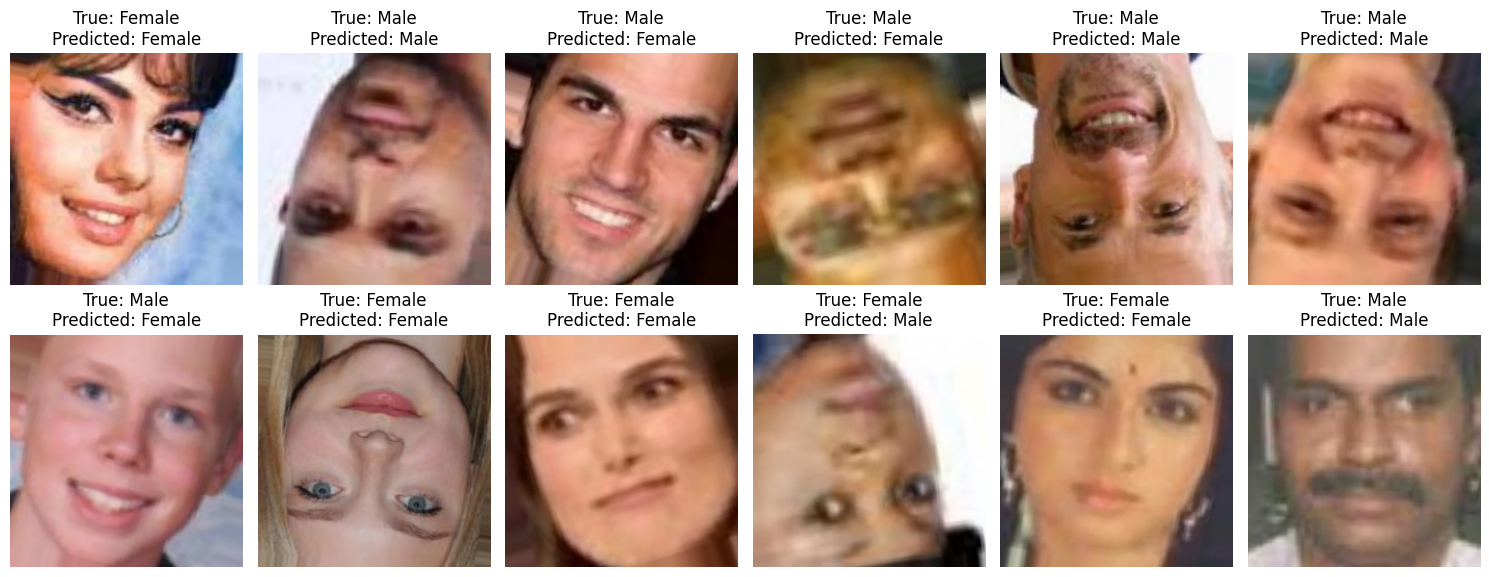

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Step 2: Extract a batch of images and true labels from the test generator
batch_images, true_labels = next(test_gen)

# Step 3: Plot the images along with true and predicted labels
num_images_to_display = 6
num_rows = 2
fig, axes = plt.subplots(num_rows, num_images_to_display, figsize=(15, 6))

for row in range(num_rows):
    for col in range(num_images_to_display):
        index = row * num_images_to_display + col
        # Plot the image
        axes[row, col].imshow(batch_images[index])
        axes[row, col].axis('off')

        # True label
        true_label = 'Female' if true_labels[index] == 1 else 'Male'

        # Predicted label
        predicted_label = 'Female' if predicted_labels[index] > 0.5 else 'Male'

        # Set title with true and predicted labels
        axes[row, col].set_title(f'True: {true_label}\nPredicted: {predicted_label}')

plt.tight_layout()
plt.show()

In [44]:
model.save("CNN_model.h5")

In [45]:
model.save("CNN_model.keras")

In [10]:
import keras
model_CNN = keras.models.load_model(r"C:\Users\sweek\OneDrive - Lambton College\Projects Main\Age and Gender Prediction\CNN_model.h5")

In [11]:
test_loss, test_accuracy = model_CNN.evaluate(test_gen)

print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

c:\Users\sweek\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


112/112 ━━━━━━━━━━━━━━━━━━━━ 81s 724ms/step - accuracy: 0.8592 - loss: 0.3248
Test loss: 0.3263722062110901
Test accuracy: 0.8602755069732666


In [14]:
# Make a prediction
predictions = model_CNN.predict(test_gen)

# Initialize an empty list to store the predicted classes
predicted_classes = []

# Iterate over the predictions
for prediction in predictions:
    # Classify each prediction as 'Female' or 'Male'
    predicted_class = 'Female' if prediction > 0.5 else 'Male'
    # Add the predicted class to the list
    predicted_classes.append(predicted_class)


112/112 ━━━━━━━━━━━━━━━━━━━━ 58s 519ms/step


In [19]:
# Convert predicted_classes to numerical values
predicted_classes_num = [1 if cls == 'Female' else 0 for cls in predicted_classes]

In [18]:
y_test = test_df['gender_index'].values

In [20]:
from sklearn.metrics import classification_report

# Print the classification report
print(classification_report(y_test, predicted_classes_num, target_names=['Male', 'Female']))

              precision    recall  f1-score   support

        Male       0.87      0.86      0.86      1855
      Female       0.85      0.85      0.85      1702

    accuracy                           0.86      3557
   macro avg       0.86      0.86      0.86      3557
weighted avg       0.86      0.86      0.86      3557



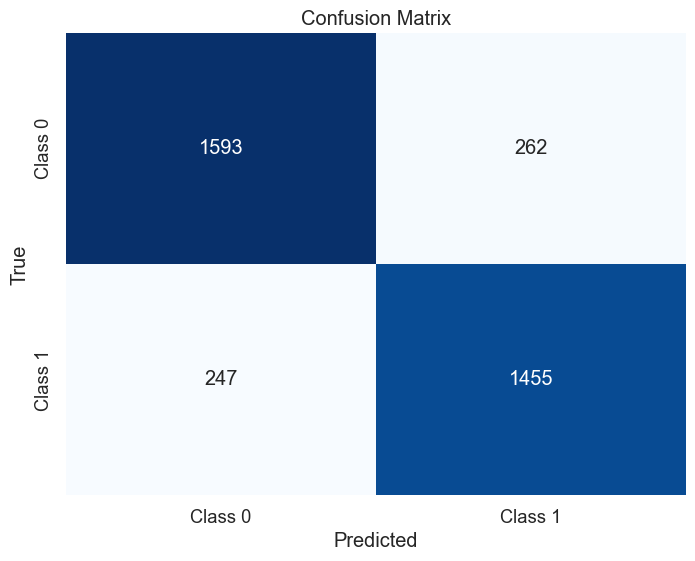

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_test, predicted_classes_num)

# Define class labels
class_names = ['Class 0', 'Class 1']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False, 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Test prediction on a custom image

In [24]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Define your ImageDataGenerator with the same parameters as during training
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
)

img_height = 224
img_width = 224

# Load the image
image = load_img(r'C:\Users\sweek\OneDrive - Lambton College\Projects Main\Age and Gender Prediction\male5.jpg', target_size=(img_height, img_width))

# Preprocess the image
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image = datagen.standardize(image)

# Make a prediction
predictions = model_CNN.predict(image)
print(predictions)
predicted_class = 'Female' if predictions > 0.5 else 'Male'

print(f"Predicted Gender: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
[[0.25102347]]
Predicted Gender: Male


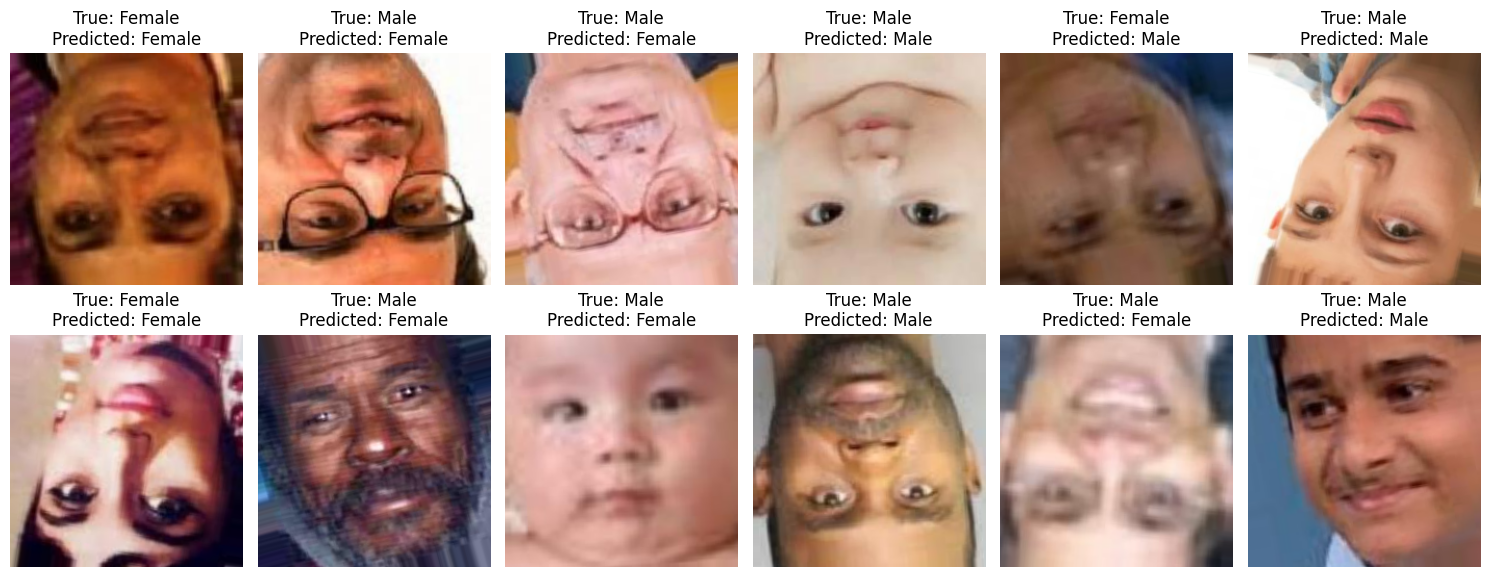

In [56]:
# Step 2: Extract a batch of images and true labels from the test generator
batch_images, true_labels = next(test_gen)

# Step 3: Plot the images along with true and predicted labels
num_images_to_display = 6
num_rows = 2
fig, axes = plt.subplots(num_rows, num_images_to_display, figsize=(15, 6))

for row in range(num_rows):
    for col in range(num_images_to_display):
        index = row * num_images_to_display + col
        # Plot the image
        axes[row, col].imshow(batch_images[index])
        axes[row, col].axis('off')

        # True label
        true_label = 'Female' if true_labels[index] == 1 else 'Male'

        # Predicted label
        predicted_label = 'Female' if predicted_labels[index] > 0.5 else 'Male'

        # Set title with true and predicted labels
        axes[row, col].set_title(f'True: {true_label}\nPredicted: {predicted_label}')

plt.tight_layout()
plt.show()